# 03. Modeling – Probability of Default (PD)

## Mục tiêu
- Xây dựng mô hình học máy dự đoán Probability of Default (PD)
- So sánh mô hình truyền thống và mô hình ML hiện đại
- Lựa chọn mô hình tốt nhất cho bước calibration và credit scoring

Lưu ý quan trọng:
- Mô hình **KHÔNG dự đoán credit score trực tiếp**
- Mô hình dự đoán **PD ∈ [0,1]**
- Credit Score (1–10) sẽ được xây dựng ở Notebook 04

In [1]:
# Mount Drive & setup môi trường
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/NCKH"
DATA_PROCESSED = f"{PROJECT_ROOT}/data/processed"
MODELS_DIR = f"{PROJECT_ROOT}/models"
SRC_DIR = f"{PROJECT_ROOT}/src"

import os, sys
os.makedirs(MODELS_DIR, exist_ok=True)
sys.path.append(SRC_DIR)

print("Environment setup completed")


Mounted at /content/drive
Environment setup completed


## Load dữ liệu đã gán Proxy Default

Dữ liệu được tạo từ:
- `01_eda FINAL`
- `02_labeling FINAL`

Bao gồm:
- Biến mục tiêu: proxy_default
- Dữ liệu nhiều năm (year)

In [2]:
import pandas as pd
import numpy as np

from config import FEATURE_COLUMNS, TARGET_COLUMN, GROUP_COLUMN, ExperimentConfig
from features import add_features

cfg = ExperimentConfig()

df = pd.read_csv(f"{DATA_PROCESSED}/data_labeled.csv")
df.shape

(453, 24)

## Feature Engineering

Thực hiện:
- Tạo các tỷ số tài chính
- Log-transform biến quy mô
- Missing indicators

Các đặc trưng này **đã được quyết định từ EDA**, không phát sinh tùy tiện.

In [3]:
# Add engineered features
df_feat = add_features(df, missing_flag_cols=cfg.MISSING_FLAG_COLS)

df_feat[FEATURE_COLUMNS + [TARGET_COLUMN]].head()

,current_ratio,cash_ratio,debt_to_equity,debt_to_assets,short_debt_ratio,gross_margin,net_margin,roa,roe,interest_coverage,ocf_to_debt,ocf_margin,selling_to_rev,admin_to_rev,interest_to_rev,is_missing_cashflow_investing,is_missing_long_term_debt,log_assets,proxy_default
0,1.520342,0.651601,0.942270,0.485138,0.467205,0.087842,0.024497,0.026693,0.051844,1.305320,0.465376,0.207203,0.040491,0.022603,0.018959,0,0,30.080598,0
1,1.555045,0.585472,1.207763,0.547053,0.339203,0.116107,0.025018,0.023226,0.051278,1.927758,0.127313,0.075019,0.056076,0.029759,0.015703,0,0,30.243888,0
2,2.920623,0.214035,0.122832,0.109395,0.383041,0.162849,0.050101,0.008792,0.009872,4.870807,1.029438,0.641705,0.025059,0.086211,0.010589,0,0,27.911733,0
3,1.590666,0.033241,0.221615,0.181411,0.305136,0.046738,0.010190,0.008208,0.010028,12.996260,0.347953,0.078365,0.004346,0.012108,0.002330,0,0,28.006131,0
4,3.845627,0.617910,0.287234,0.223141,0.076868,-0.001703,0.038562,0.064863,0.083494,-1.454116,-1.431025,-0.189840,0.000291,0.001520,0.002417,1,1,27.186774,1


## Train–Test Split theo thời gian (Anti–Data Leakage)

Nguyên tắc:
- Train: year ≤ TRAIN_YEAR
- Test: year = TEST_YEAR

Lý do:
- Dữ liệu tài chính có yếu tố thời gian
- Tránh sử dụng thông tin tương lai
- Phù hợp mô hình rủi ro tín dụng

In [4]:
# Time-based split
train_df = df_feat[df_feat["year"] <= cfg.TRAIN_YEAR].copy()
test_df  = df_feat[df_feat["year"] == cfg.TEST_YEAR].copy()

train_df.shape, test_df.shape

((228, 41), (225, 41))

## Kiểm tra mất cân bằng lớp (Class Imbalance)

Bài toán PD thường có tỷ lệ default thấp.
Cần đánh giá trước khi huấn luyện.

In [5]:
# default rate
train_df[TARGET_COLUMN].mean(), test_df[TARGET_COLUMN].mean()

(np.float64(0.38596491228070173), np.float64(0.36))

## Các mô hình được so sánh

1. Logistic Regression (baseline – chuẩn tín dụng)
2. Random Forest (phi tuyến)
3. Gradient Boosting (LightGBM / XGBoost – ML hiện đại)
4. SVM (RBF kernel – so sánh học thuật)

Danh sách này:
- Đủ mạnh để đánh giá
- Không phô trương
- Đáp ứng yêu cầu đề cương

In [6]:
# Build & train models
from train import build_models, fit_and_eval

models = build_models(
    y_train=train_df[TARGET_COLUMN].values,
    random_state=cfg.RANDOM_STATE
)

metrics, fitted_models = fit_and_eval(
    models,
    train_df=train_df,
    test_df=test_df
)

metrics


[LightGBM] [Info] Number of positive: 88, number of negative: 140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,ROC_AUC,PR_AUC,KS,Brier,test_default_rate
2,LightGBM,0.998200,0.997300,0.973765,0.020201,0.36
1,RandomForest,0.990226,0.986067,0.906636,0.046037,0.36
0,LogisticRegression,0.878001,0.826743,0.640432,0.137088,0.36
3,SVM_RBF,0.866298,0.802693,0.611111,0.142752,0.36


## Đánh giá mô hình

Sử dụng các chỉ số:
- ROC-AUC: khả năng phân biệt
- PR-AUC: phù hợp dữ liệu mất cân bằng
- KS statistic: tiêu chuẩn tín dụng
- Brier score: độ chính xác xác suất

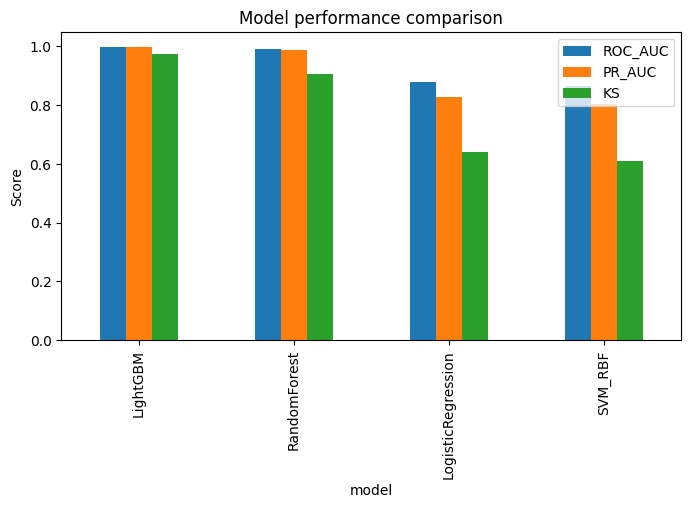

In [7]:
# Visualize performance
import matplotlib.pyplot as plt

metrics.set_index("model")[["ROC_AUC","PR_AUC","KS"]].plot.bar(figsize=(8,4))
plt.title("Model performance comparison")
plt.ylabel("Score")
plt.show()


## Lựa chọn mô hình tốt nhất

Tiêu chí:
- ROC-AUC cao
- KS cao
- PR-AUC ổn định
- Không overfitting rõ rệt

Mô hình tốt nhất sẽ được sử dụng cho:
- Calibration
- Credit Scoring (1–10)


In [8]:
best_model_name = metrics.iloc[0]["model"]
best_model = fitted_models[best_model_name]

best_model_name

'LightGBM'

## Lưu mô hình

Việc lưu mô hình đảm bảo:
- Tái lập kết quả
- Phục vụ calibration & scoring
- Minh bạch khi phản biện

In [9]:
# Save model
from train import save_models

save_models({best_model_name: best_model}, MODELS_DIR)

## Tổng kết Notebook 03

Notebook này đã:
- Huấn luyện các mô hình dự đoán PD
- So sánh mô hình truyền thống và ML hiện đại
- Lựa chọn mô hình tối ưu dựa trên nhiều tiêu chí

Kết quả là mô hình PD đầu vào cho:
- Calibration
- Chuyển PD → Credit Score (1–10)